In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px


In [48]:
import os
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

df_merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))

print(df_merged_og.shape)

(116303, 70)


/var/folders/r9/gyc839012fz27dyc44xgpv9r0000gn/T/ipykernel_12192/1724020693.py:5: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))


In [86]:
df = df_merged_og.copy()

#### Data preprocessing
- remove observations before 1989
- generate unique ID for each country in each month
- drop countries with very few GDELT entries
- replace event counts with event shares
- generate and normalise sum of 'total_events'
- generate weighted stocks of event shares
- fill NaN death values with 0
- add historical values for deaths (rolling mean)

In [87]:
# drop observations prior to 1989 (which is when UCDP data starts)
df = df[df['year'] >= 1989]
print(df.shape)

# check time period
print(df.year.min())
print(df.year.max())

print('number of countries:', df.isocode.nunique())
print('number rows without deaths', df.deaths.isna().sum())

(92637, 70)
1989
2023
number of countries: 240
number rows without deaths 79448


In [88]:
#  generate unique ID for each country in each month
df['country_month_id'] = df['MonthYear'].astype(str) + '_' + df['isocode']

In [89]:
# drop countries with with <413 Month Entries in GDELT
# exception: 'SSD'
isocodes_to_drop = ['ABW', 'AIA', 'AND', 'ASM', 'BVT', 'COK', 'CXR', 'CYM', 'FLK', 'FRO', 'GGY', 'GLP', 'GUF', 'HMD', 'IMN', 'IOT', 'KIR', 'KNA', 'LCA', 'LIE', 'MTQ', 'MYT', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'REU', 'SHN', 'SJM', 'SMR', 'SPM', 'TCA', 'TKL', 'TUV', 'VCT', 'VGB', 'WLF']
df = df[~df['isocode'].isin(isocodes_to_drop)]

print('number of countries:', df.isocode.nunique())
df.shape

number of countries: 201


(82258, 71)

In [90]:
# generate column that sums the number of events for each country-year
count_columns = df.filter(regex='^count_').columns.tolist()
df['total_events'] = df[count_columns].sum(axis=1)

# generate new 'share' columns from the original GDELT count columns
new_column_names = ['event_share_{}'.format(i) for i in range(1, 21)]

for i, column_name in enumerate(new_column_names):
    df[column_name] = df['count_events_{}'.format(i+1)] / df['total_events']*100

# drop original count columns
df = df.drop(columns=count_columns)

Index(['MonthYear', 'isocode', 'month', 'year', 'country', 'deaths',
       'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths',
       'country_month_id', 'total_events', 'event_share_1', 'event_share_2',
       'event_share_3', 'event_share_4', 'event_share_5', 'event_share_6',
       'event_share_7', 'event_share_8', 'event_share_9', 'event_share_10',
       'event_share_11', 'event_share_12', 'event_share_13', 'event_share_14',
       'event_share_15', 'event_share_16', 'event_share_17', 'event_share_18',
       'event_share_19', 'event_share_20', 'norm_total_events'],
      dtype='object')

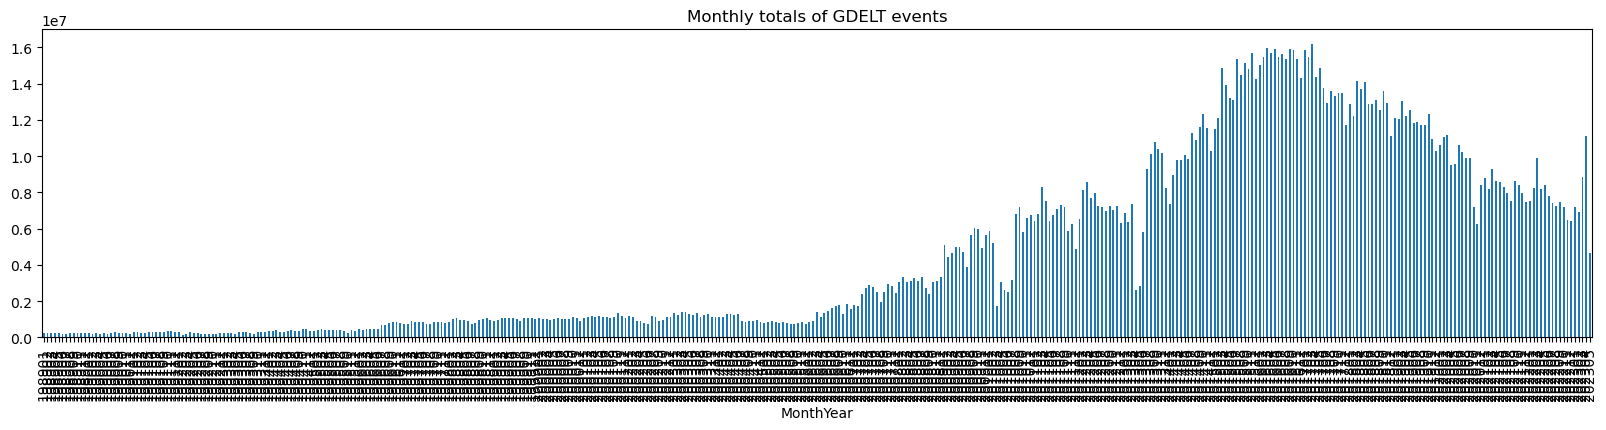

In [91]:
# normalise the events (dividing by the yearly totals)

# plot yearly totals
monthly_totals = df.groupby('MonthYear')['total_events'].sum()
monthly_totals.plot.bar(figsize=(20, 4), title='Monthly totals of GDELT events')

# normalise the events (dividing by the yearly totals)
df['norm_total_events'] = df.groupby('MonthYear')['total_events'].transform(lambda x: x / monthly_totals[x.name])

df.columns

In [102]:
# fill missing deaths with 0
death_columns = ['deaths', 'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths']
df[death_columns] = df[death_columns].fillna(0)

# fill missing events with with 0
event_share_columns= df.filter(like='event_share').columns.tolist()
df[event_share_columns] = df[event_share_columns].fillna(0)

In [93]:
#adding columns for past homicides (rolling sum)

lcols = (df.groupby('isocode')['deaths'] # for each country
         .transform(lambda x: x.rolling(y, min_periods=1).sum()) # rolling sum of best
         .rename('past' + str(y-1)) 
         for y in [2, 3, 7, 12])

df = df.join(pd.DataFrame(lcols).transpose())


In [94]:
def stock_simple(x: pd.Series, decay: float = 0.8):
    # xs is a stock of x inflow with a decay of 0.8
    # nans = x.isnull()
    x = list(x.fillna(0))
    xs = [] 
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            xs.append(x[n] + decay * xs[n-1])
    #list(np.where(nans, np.nan, xs))
    return xs

def stock_weighted(x: pd.Series, w: pd.Series, decay:float = 0.8):
    # xs is a stock of x inflow, weighted by w, with a decay of 0.8
    x = list(x.fillna(0))
    ws = stock_simple(w) # below this is the number of tokens for that country-month, which the stock_simple function turns into a discounted series
    w = list(w.fillna(0))
    xs = []
    
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            num = w[n]*x[n] + decay * ws[n-1] * xs[n-1]
            
            # word stock for topic = tokens * topic share + decay * past word stock for topic
            # past word stock for topic = total words stock * topic stock share
            
            if ws[n]>0:
                xs.append(num/ws[n])
            else:
                xs.append(num)
    return xs



decay = 0.8

# weighted stock of events shares
lcols_gdelt1 = (df.groupby('isocode')
        .apply(lambda x: stock_weighted(x['event_share_'+str(t)], x['total_events'], decay=decay))
        .explode().reset_index(drop=True)
        .rename('event' + str(t) +'_w_stock')
        for t in range(1,21))
df = df.join(pd.DataFrame(lcols_gdelt1).transpose())

# simple stock of events
#lcols_gdelt2 = (df.groupby('isocode')
#        .apply(lambda x: stock_simple(x['event_share_'+str(t)], decay=decay))
#        .explode().reset_index(drop=True)
#        .rename('event' + str(t) +'_w_stock')
#        for t in range(1,21))
#df = df.join(pd.DataFrame(lcols_gdelt2).transpose())


In [96]:
df.columns

Index(['MonthYear', 'isocode', 'month', 'year', 'country', 'deaths',
       'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths',
       'country_month_id', 'total_events', 'event_share_1', 'event_share_2',
       'event_share_3', 'event_share_4', 'event_share_5', 'event_share_6',
       'event_share_7', 'event_share_8', 'event_share_9', 'event_share_10',
       'event_share_11', 'event_share_12', 'event_share_13', 'event_share_14',
       'event_share_15', 'event_share_16', 'event_share_17', 'event_share_18',
       'event_share_19', 'event_share_20', 'norm_total_events', 'past1',
       'past2', 'past6', 'past11', 'event1_w_stock', 'event2_w_stock',
       'event3_w_stock', 'event4_w_stock', 'event5_w_stock', 'event6_w_stock',
       'event7_w_stock', 'event8_w_stock', 'event9_w_stock', 'event10_w_stock',
       'event11_w_stock', 'event12_w_stock', 'event13_w_stock',
       'event14_w_stock', 'event15_w_stock', 'event16_w_stock',
       'event17_w_stock', 'event18

#### Clustering



/Users/margheritaphilipp/miniforge3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/margheritaphilipp/miniforge3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/margheritaphilipp/miniforge3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/margheritaphilipp/miniforge3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

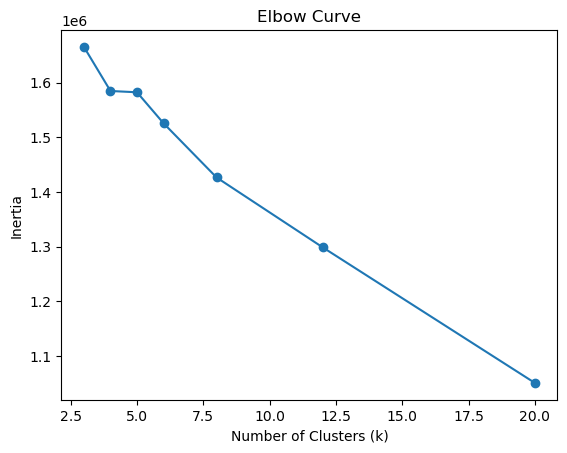

In [104]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# slelect columns for clustering
columns_for_clustering = ['deaths', 'norm_total_events'] + event_share_columns
data = df[columns_for_clustering]

# normalise data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# pick cluster range
k_values = [3,4,5,6,8,12,20,] #range(1, 20)

# initialize list to store inertia values
inertia_values = []

#perform k-means clustering for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia_values.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [109]:
# Determine the optimal number of clusters based on the elbow point
# In this example, let's assume the optimal number of clusters is 3
optimal_k = 6

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(normalized_data)

# Assign observations to clusters
cluster_labels = kmeans.labels_

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

/Users/margheritaphilipp/miniforge3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


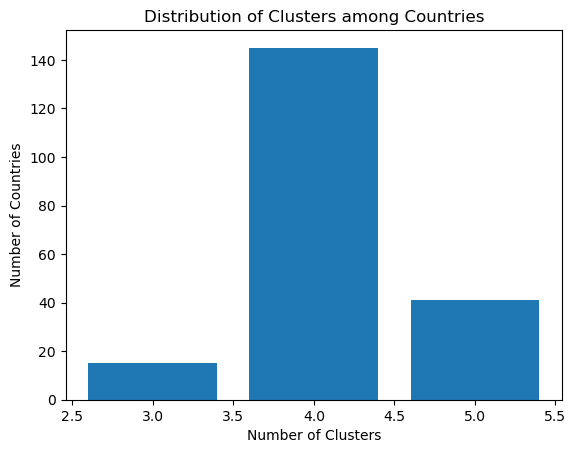

In [110]:
# Count the number of countries with 1, 2, and 3 clusters
cluster_counts = df.groupby('isocode')['Cluster'].nunique()
count_of_clusters = cluster_counts.value_counts().sort_index()

# Plot the bar chart
plt.bar(count_of_clusters.index, count_of_clusters.values)
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Countries')
plt.title('Distribution of Clusters among Countries')
plt.xticks(rotation=0)
plt.show()


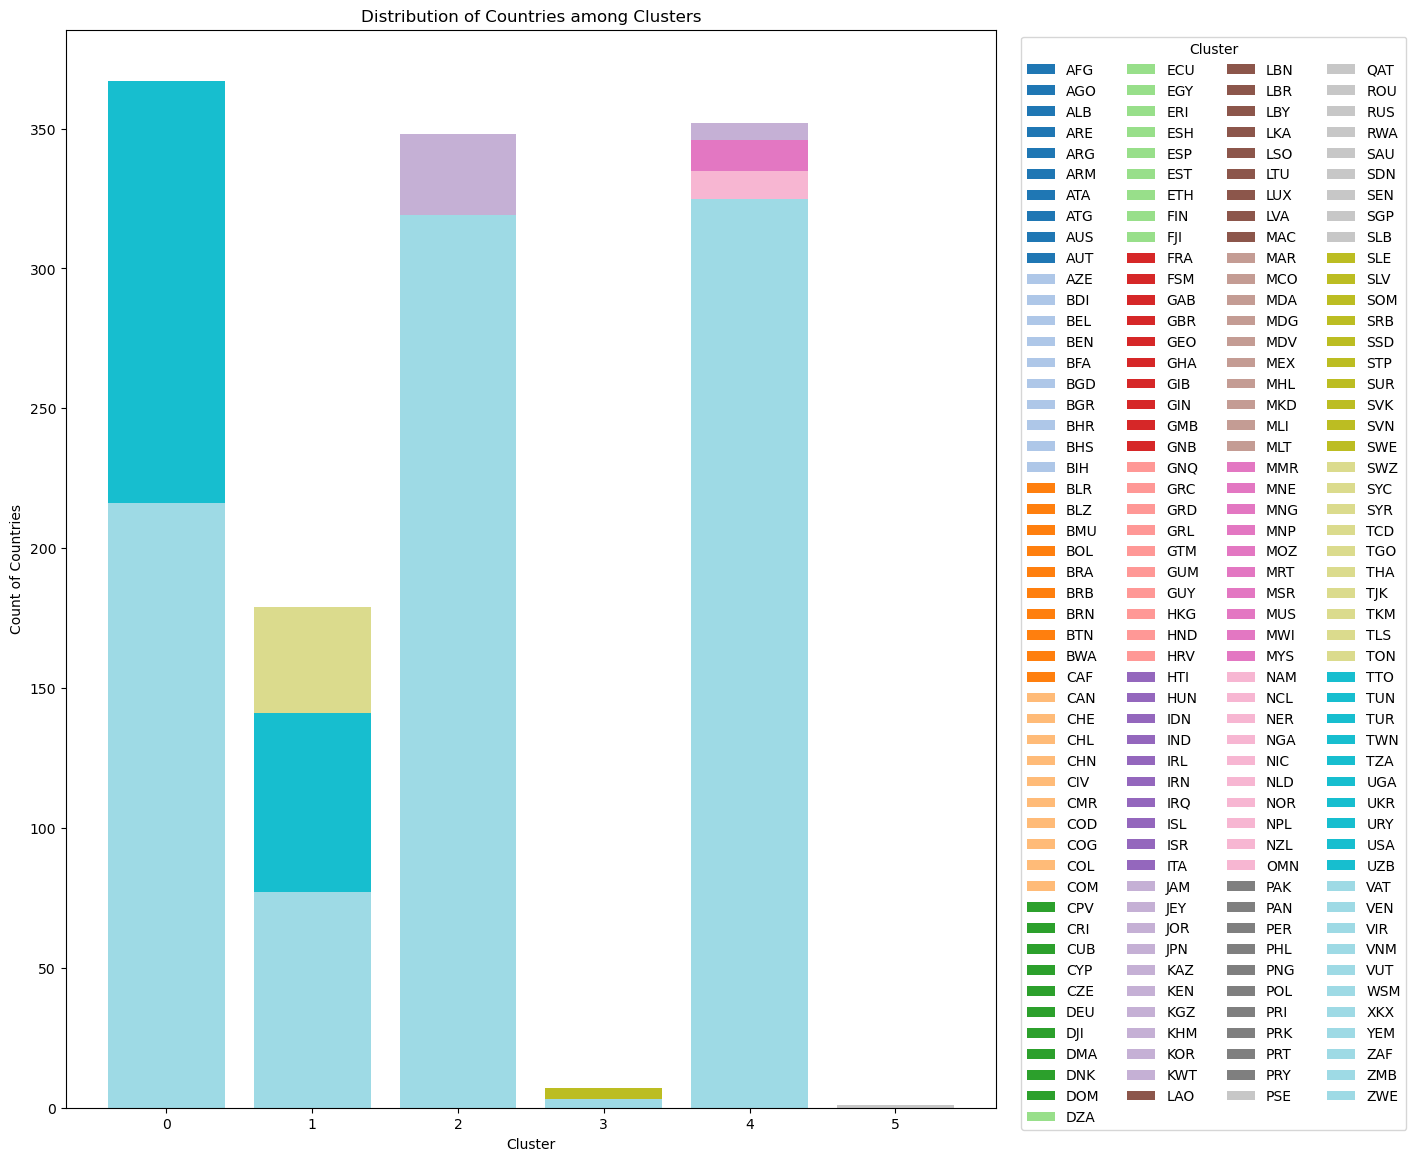

In [115]:
# Count the number of countries in each cluster
country_counts = df.groupby('Cluster')['isocode'].value_counts().unstack().fillna(0)

# Plot the large graph
plt.figure(figsize=(12,14))
colors = plt.cm.get_cmap('tab20', len(country_counts.columns))
for i, (column, color) in enumerate(zip(country_counts.columns, colors.colors)):
    plt.bar(country_counts.index, country_counts[column], label=column, color=color)
plt.xlabel('Cluster')
plt.ylabel('Count of Countries')
plt.title('Distribution of Countries among Clusters')

# Create a smaller legend in 4 columns on the side
legend_handles = [plt.bar(0, 0, color=color, label=label) for label, color in zip(country_counts.columns, colors.colors)]
plt.legend(handles=legend_handles, title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=4)

plt.show()

